# Course 8 Summative DataVine


In [1]:

#Summative Lab- DataVine Analytics

#I followed the video walkthrough in order to separate the tasks appropriately. 
#Step 1 Import and clean data. 
#Step 2 PCA Hyperparameter KNN for wine dataset
#Step 3 PCA and cosine similarity to recommend feeds with similar weight performance
#Step 4 — unsupervised learning to find patterns in state‐level crime data.





# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_wine


In [10]:

# Dataset 1: Wine (for KNN) 
wine_df = pd.read_csv('wine_data.csv')
# Ensure 'target' column exists; if not, try to infer common alternatives
if 'target' not in wine_df.columns:
    for alt in ['class','label','variety','wine_class','cultivar']:
        if alt in wine_df.columns:
            wine_df = wine_df.rename(columns={alt:'target'})
            break

# Dataset 2: Chickwts (for Recommendation)
chickwts = pd.read_csv('chickwts_data.csv')[['weight','feed_name']].rename(columns={'feed_name':'feed'}).dropna()

# Dataset 3: USArrests (for PCA & Clustering)
usarrests = pd.read_csv('arrests_data.csv').dropna()

for name, df in {"Wine": wine_df, "Chickwts": chickwts, "USArrests": usarrests}.items():
    print(f"{name} NA counts:\n{df.isna().sum()}\n")

# Display dataset summaries
print("Wine Dataset:\n", wine_df.head(), "\n")
print("Chickwts Dataset:\n", chickwts.head(), "\n")
print("USArrests Dataset:\n", usarrests.head(), "\n")


Wine NA counts:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

Chickwts NA counts:
weight    0
feed      0
dtype: int64

USArrests NA counts:
Unnamed: 0    0
Murder        0
Assault       0
UrbanPop      0
Rape          0
dtype: int64

Wine Dataset:
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80  

In [3]:

# Split dataset into train/test sets
X = wine_df.drop(columns=["target"])   # Features
y = wine_df["target"]                  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Hyperparameter tuning: Finding optimal k and distance metric
param_grid = {'n_neighbors': range(1, 21), 'metric': ['euclidean', 'manhattan', 'minkowski']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Best parameters
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
print(f"Best k: {best_k}, Best Distance Metric: {best_metric}")

# Train the best k-NN model
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X_train_pca, y_train)

# Predict & evaluate
y_pred = knn.predict(X_test_pca)

print("k-NN Classification Report:\n", classification_report(y_test, y_pred))
print(f"k-NN Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Best k: 20, Best Distance Metric: euclidean
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00         8

    accuracy                           0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36

k-NN Accuracy: 0.97


#Step 2 Breakdown of PCA Hyperparameter KNN for wine dataset

The results
Best model: k-NN with k = 20, metric = 'euclidean'.
Test accuracy: 0.97 (35/36 correct).
Only one error (a class-1 wine predicted as class-0).

Hyperparameters you used
Tuned with GridSearchCV
n_neighbors: 1–20 best = 20
metric: euclidean, manhattan, minkowski → best = 'euclidean'
(cv=5, scoring='accuracy')
Defaults set
k-NN: weights='uniform', algorithm='auto', leaf_size=30 (defaults)
PCA setting
n_components=0.95 (retain ≥95% variance)

Business Reference- 
High accuracy means the model can reliably label wines for inventory and quality control. This one error suggests most decisions are stable; borderline cases should be flagged for manual review. Overall our program should work to classify wines  into the three wine varieties based on chemical properties



In [4]:
# 1) Normalize feed labels  
chickwts['feed'] = chickwts['feed'].astype(str).str.strip()

# 2) Standardize the weight feature 
scaler = StandardScaler()
chickwts_scaled = scaler.fit_transform(chickwts[['weight']])

# 3) PCA 1 principal component 
pca = PCA(n_components=1, random_state=42)
chickwts_pca = pca.fit_transform(chickwts_scaled)   

# 4) Cosine similarity with Feed using the PCA output 
similarity_matrix = cosine_similarity(chickwts_pca) # feeds × feeds

# 5) Recommend similar feeds
def recommend_feeds(feed_name, num_recommendations=3):
    # choose the first instance row for the given feed 
    idx_list = chickwts.index[chickwts["feed"] == feed_name].tolist()
    if not idx_list:
        return f"{feed_name} not in data"
    feed_index = idx_list[0]
    similarity_scores = list(enumerate(similarity_matrix[feed_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    recommended_feeds = [chickwts.iloc[i]["feed"] for i, score in similarity_scores[1:num_recommendations+1]]
    return recommended_feeds

# 6) Feed Results
example_feed = chickwts['feed'].iloc[0] 
print(f"Recommended feeds for '{example_feed}':", recommend_feeds(example_feed))

Recommended feeds for 'FirstPeck': ['ChickStart Plus', 'EarlyGrow Formula', 'HatchMate Premier']


In [5]:
#PERFORMED DATA CHECKS TO REVIEW AND DOUBLE CHECK MY RESULTS

# See each feed’s PC value 
pc1 = pd.Series(chickwts_pca.ravel(), index=chickwts['feed'])
print(pc1.sort_values().to_frame('pc1').head(10))   # lowest 10
print(pc1.sort_values(ascending=False).to_frame('pc1').head(10))  # highest 10

# target feed
target = "FirstPeck"
sims = pd.Series(similarity_matrix[chickwts['feed'] == target][0], index=chickwts['feed'])
print("\nSimilarity to all feeds from", target)
print(sims.sort_values(ascending=False).head(10))


# Show each feed’s PC1 
pc1 = pd.Series(chickwts_pca.ravel(), index=chickwts['feed'], name='pc1')
print(pc1.sort_values().head(10))
print(pc1.sort_values(ascending=False).head(10))

# Count how many feeds are tied at +1.0 and -1.0 for the target (evidence of cosine)
target = "FirstPeck"
idx = chickwts.index[chickwts['feed'] == target][0]
sims = pd.Series(similarity_matrix[idx], index=chickwts['feed'])
print("\nCosine similarity values and counts:")
print(sims.value_counts().sort_index())

                           pc1
feed                          
FirstPeck            -1.541437
YolkPerfect Premium  -1.487374
WeightGain Pro       -1.191721
HatchMore Premium    -1.105886
HatchlingEssentials  -1.103025
MuscleBuilder Pro    -1.097807
MatureBlend Complete -1.057333
ProteinPeak Complete -1.054875
FinishLine Enhanced  -1.014329
FertilityMax Formula -0.972589
                              pc1
feed                             
HatchSuccess Formula     2.710906
FecundityBoost Complete  2.622210
NestResult Formula       2.356122
MeatMax Complete         2.267426
BreederPerfect Plus      2.241339
PulletDevelop Formula    1.918555
LayerLuxe Complete       1.907424
ReproSuccess Formula     1.823945
RapidGrow Complete       1.646553
MeatMaker Premium        1.557857

Similarity to all feeds from FirstPeck
feed
FirstPeck              1.0
ChickStart Plus        1.0
EarlyGrow Formula      1.0
HatchMate Premier      1.0
PeepNourish            1.0
NestStart Gold         1.0
StartRight Fo

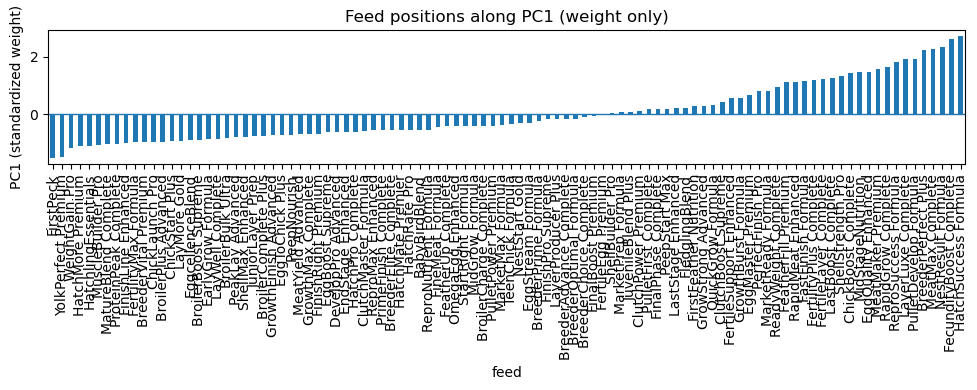

In [6]:
# Simple bar plot of PC1 so the two sides are visible
plt.figure(figsize=(10,4))
pc1.sort_values().plot(kind='bar')
plt.axhline(0, linewidth=1)
plt.title("Feed positions along PC1 (weight only)")
plt.ylabel("PC1 (standardized weight)")
plt.tight_layout()
plt.show()

#Step 3 REVIEW USING PCA AND COSINE SIMILARITY, RECOMMENDED FEEDS



- Winning feed: FirstPeck, PC1 ≈ −1.54 well below the average weight.
- The PC1 tables list feeds farthest below the mean and farthest above the mean.  
I standardized the weight, then did PCA for 1 component. I computed the cosine similarity. In one dimension, cosine is basically +1 if two feeds are on the same side of the mean and −1 if they’re on opposite sides.

Business Recommendation:
My recommendations are other feeds on the same side of the mean as FirstPeck. ChickStart Plus, EarlyGrow Formula, *HatchMate Premier are most similar by definition. With a tie our function returns the first three in the data order. The most similar feeds are ChickStart Plus, EarlyGrow Formula, *HatchMate Premier.


Selected features: ['Assault', 'UrbanPop', 'Rape']


C:\Users\pbhun\anacondareinstall\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pbhun\anacondareinstall\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\pbhun\anacondareinstall\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pbhun\anacondareinstall\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~

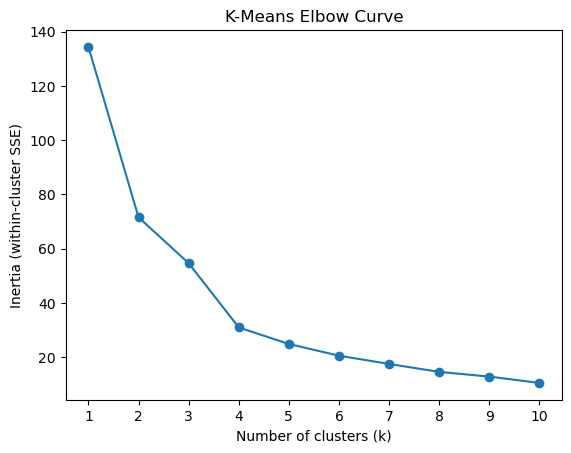

Best number of clusters for K-Means: 10


In [7]:
#STEP 4. USARRESTSDATA

# Standardizing the data
scaler = StandardScaler()
# 1) Get raw numeric features 
if not np.issubdtype(usarrests.iloc[:,0].dtype, np.number):
    X_raw = usarrests.iloc[:, 1:].copy()
else:
    X_raw = usarrests.copy()

# 2) Pick top-3 most variable features (unsupervised)
top3 = X_raw.var().nlargest(3).index.tolist()
print("Selected features:", top3)

# 3) Standardize ONLY selected features
scaler = StandardScaler()
usarrests_selected = scaler.fit_transform(X_raw[top3])

# 4) PCA to 2 components for visualization 
pca = PCA(n_components=2, random_state=42)
usarrests_pca = pca.fit_transform(usarrests_selected)

# Hyperparameter Tuning for K-Means (Finding best number of clusters)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(usarrests_pca)
    inertia.append(kmeans.inertia_)


Ks = list(range(1, 11))  
plt.figure()
plt.plot(Ks, inertia, marker='o')
plt.xticks(Ks)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('K-Means Elbow Curve')
plt.show()


best_k = inertia[1:].index(min(inertia[1:])) + 2
print(f"Best number of clusters for K-Means: {best_k}")


In [8]:
# K-Means: fixed at k=4 from elbow curve - optimal k
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
usarrests["KMeans_Cluster"] = kmeans.fit_predict(usarrests_pca)

# GMM: choose k by BIC
lowest_bic = np.inf
best_gmm_k = None
gmm_best = None

for k in range(1, 11):
    g = GaussianMixture(n_components=k, random_state=42, n_init=5)
    g.fit(usarrests_pca)
    bic = g.bic(usarrests_pca)
    if bic < lowest_bic:
        lowest_bic, best_gmm_k, gmm_best = bic, k, g

print(f"Best number of clusters for GMM (BIC): {best_gmm_k}")

# Use the BIC-selected
usarrests["GMM_Cluster"] = gmm_best.predict(usarrests_pca)

# show confidence of assignments
usarrests["GMM_Prob"] = gmm_best.predict_proba(usarrests_pca).max(axis=1)


C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known

Best number of clusters for GMM (BIC): 1


C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pbhun\anacondareinstall\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known

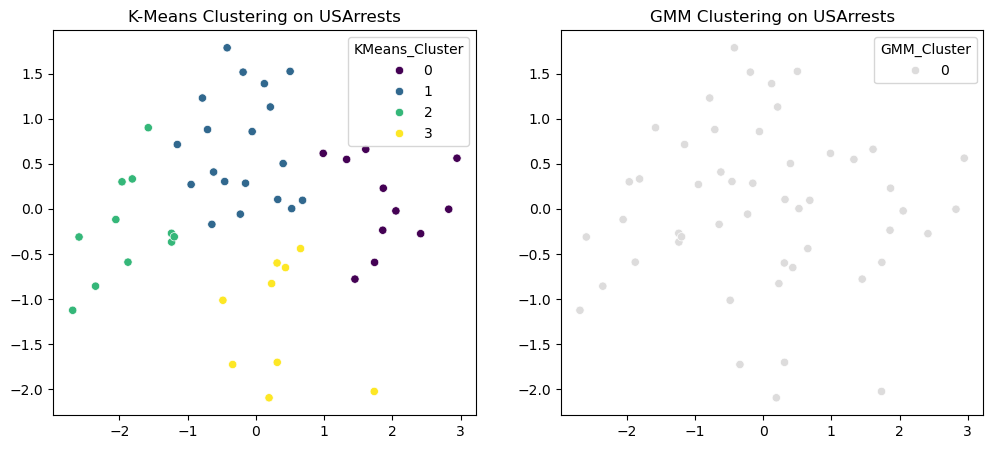

In [9]:
# Visualize Clusters
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=usarrests_pca[:, 0], y=usarrests_pca[:, 1],
                hue=usarrests["KMeans_Cluster"], palette="viridis")
plt.title("K-Means Clustering on USArrests")

plt.subplot(1,2,2)
sns.scatterplot(x=usarrests_pca[:, 0], y=usarrests_pca[:, 1],
                hue=usarrests["GMM_Cluster"], palette="coolwarm")
plt.title("GMM Clustering on USArrests")

plt.show()

#Step 4 — Regional Crime Pattern Analysis (USArrests)


Optimal K = 4 based on the elbow curve. The clusters are useful operational measurements for reporting and planning.  GMM (BIC = 1) indicates the distribution has no strong evidence of naturally separated Gaussian clusters.

Business Recommendation
Treat the groupings as high crime profiles 
The GMM/BIC’s single component implies weak natural separation; segmentation is for communication and resource prioritization, not a claim of inherent classes. A 4-segment K-Means view provides actionable policy buckets, while GMM/BIC cautions that the underlying pattern is not truly distinct natural clusters.

